In [3]:
import os, sys

In [4]:
# Check if extracted data folder exists
usingColab = 1
if usingColab:
  if(not os.path.exists('SYSC4415W23_A3_dataset')):

    # Download and extract the dataset if the zip file does not exist
    if (not os.path.isfile('SYSC4415W23_A3_dataset.zip')):
      !wget https://github.com/jrgreen7/SYSC4906/releases/download/Assignment3/SYSC4415W23_A3_dataset.zip
      !unzip SYSC4415W23_A3_dataset.zip

  datasetPath = r"SYSC4415W23_A3_dataset"

else:
  datasetPath = r"C:/Users/googl/Documents/ML/A3_Dataset/SYSC4415W23_A3_dataset"

In [6]:
import pandas as pd

train_labels = pd.read_csv(f'{datasetPath}/train/labels.csv')
train_features = pd.read_csv(f'{datasetPath}/train/extracted_features.csv')

train_features.set_index(keys='sample_id', inplace=True)
train_features.sort_values(by=['sample_id'], inplace=True)
train_labels.set_index(keys='sample_id', inplace=True)
train_labels.sort_values(by=['sample_id'], inplace=True)

print(f'Shape of original features: {train_features.shape}')

number of original features: (1621, 7047)


### Feature Selection 
Using variance thresholding, dropping any features with NaN values and using univariate stats to determince the top 50% of features for classification to determine which features are useful.

In [21]:
# Remove features that have very low variance
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif

sel = VarianceThreshold(threshold=(0.95 * (1 - 0.95)))
sel.fit_transform(train_features)
cols = [column for column in train_features.columns 
          if column not in train_features.columns[sel.get_support()]]
trimTrainFeat = train_features.drop(columns=cols)
print(f'Shape after variance threshold of .9525: {trimTrainFeat.shape}')

toDrop_o = trimTrainFeat.isnull().sum().to_numpy()
toDrop = [True]*len(toDrop_o)
for val in range(len(toDrop)):
    if toDrop_o[val] > 0:
        toDrop[val] = False
    else:
        toDrop[val] = True

dropped = [column for column in trimTrainFeat.columns 
          if column not in trimTrainFeat.columns[toDrop]]
dataset = trimTrainFeat.drop(columns=dropped)

print(f'Number of reduced features from removing NaN values: {dataset.shape}')

# Using top 50% of features
nextSel = SelectKBest(score_func=f_classif, k=2700)
nextSel.fit_transform(dataset, train_labels['label'])
cols = [column for column in dataset.columns 
          if column not in dataset.columns[nextSel.get_support()]]
dataset = dataset.drop(columns=cols)
print(f'Feature data shape after SelectKBest using f-value stats: {dataset.shape}')

# Free up memory for next tasks
del trimTrainFeat, toDrop, dropped, cols, sel, nextSel, toDrop_o


/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_variance_threshold.py:111: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)


Shape after variance threshold of .9525: (1621, 5423)
Number of reduced features from removing NaN values: (1621, 5402)
2702
Feature data shape after SelectKBest using f-value stats: (1621, 2700)


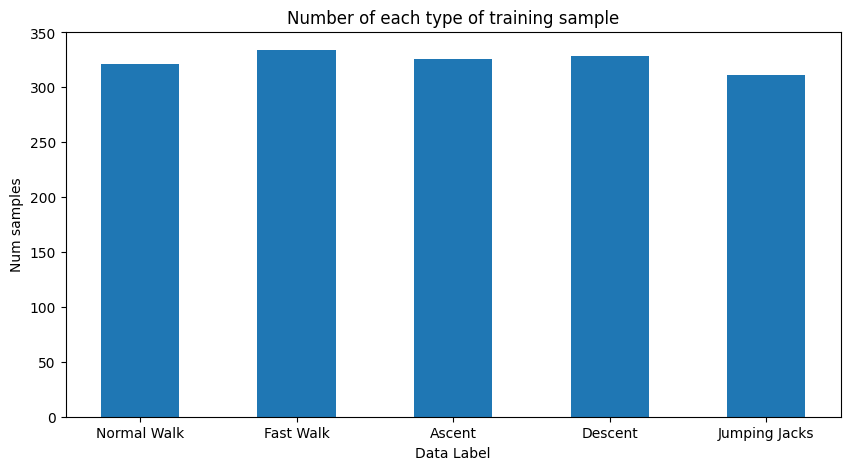

In [38]:
# Data visualization
import matplotlib.pyplot as plt
counts = train_labels.value_counts(subset=['label'])
keys = ['Normal Walk', 'Fast Walk', 'Ascent', 'Descent', 'Jumping Jacks']
vals = [counts[0],counts[1], counts[2], counts[3], counts[4]]

fig = plt.figure(figsize=(10,5))
plt.bar(x=keys, height=vals, width=0.5)
plt.xlabel("Data Label")
plt.ylabel("Num samples")
plt.title("Number of each type of training sample")
plt.show()

# No class imbalance

#### Data Loading and organization

In [22]:
from torch.utils.data import DataLoader
batchSize = 128
tr_split = 1140 # ~70% of labelled data
v_split = 320   # ~20% of labelled data
te_split = 161  # ~10% of labelled data

print(dataset.head(5))
print(train_labels.head(5))

# dataset['label'] = train_labels['label']
# dataset = dataset.sample(frac=1) # Shuffle rows before breaking into sets

# trainSet = dataset.iloc[:tr_split]                # Shape: 1140, 2701
# valSet = dataset.iloc[tr_split:tr_split+v_split]  # Shape: 320, 2701
# testSet = dataset.iloc[tr_split+v_split:]         # Shape: 161, 2701

# trainL = DataLoader(dataset=trainSet, batch_size=batchSize, shuffle=True)
# valL =   DataLoader(dataset=valSet, batch_size=batchSize, shuffle=True)
# testL =  DataLoader(dataset=testSet, batch_size=batchSize, shuffle=True)


           az__variance_larger_than_standard_deviation  az__has_duplicate  \
sample_id                                                                   
1                                                  1.0                1.0   
2                                                  1.0                1.0   
3                                                  1.0                1.0   
4                                                  1.0                1.0   
6                                                  1.0                1.0   

           az__sum_values  az__abs_energy  az__mean_abs_change  az__median  \
sample_id                                                                    
1              -11.405649     2958.427875             0.285573     -0.3230   
2                4.430022      816.786905             0.127496     -0.0784   
3              136.485847    19606.818781             1.177862      1.1600   
4              175.151247     5355.340251             0.460815     -0.

### Building model
**Hyperparameters**: 
- Learning rate: Using effective LR calculated from base LR using:
$$\eta_{eff} = \frac{B\eta_{base}}{256}$$
- Input size: 2700
- Output size: 5 (1 per class label)
- Hiddel layers: 1
- Nodes/hidden layer: 1800 (2/3 of input size, since input size > num samples)

In [50]:
from sklearn.neural_network import MLPClassifier
lr_base = 0.0001

lr = (batchSize*lr_base)/256
MLP = MLPClassifier((1800,), 'relu', solver='lbfgs', learning_rate_init=lr)
trainData = trainSet.iloc[:, :-1] # 1140, 2700
trainLabels = trainSet.iloc[:,-1] # 1140, 1
MLP.fit(trainData, trainLabels)



/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:528: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  opt_res = scipy.optimize.minimize(


MLPClassifier(hidden_layer_sizes=(1800,), learning_rate_init=5e-05,
              solver='lbfgs')